In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [2]:
def ImportToDf(path, delimiter = None, header = 0, names = []):
    if names:
        return pd.read_csv(path, delimiter = delimiter, header = header, names = names)
    return pd.read_csv(path, delimiter = delimiter, header = header)

def NormalizeDf(df):
    norm = lambda x: np.sqrt(np.square(x[1:]).sum())
    norms = df.apply(norm, axis = 1)
    to_remove = norms[norms==0].index.values
    
    df.drop(to_remove, axis=0, inplace=True)
    df = df.reset_index(drop=True)
    
    normalize = lambda x: x/np.linalg.norm(x)
    df.iloc[:,1:] = df.iloc[:,1:].apply(normalize, axis = 1)
    return df

def WeightedGraph(df, threshold = 0):
    df['WEIGHT'] = 1 
    df = df.groupby(['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], as_index = False).sum()
    df = df.sort_values(by='WEIGHT', ascending = False)
    df = df[df.WEIGHT > threshold]
    return df

def OnlyEmbeddedNodes(df, EMB):
    return df[(df.SOURCE_SUBREDDIT.isin(EMB.NODE.values)) & (df.TARGET_SUBREDDIT.isin(EMB.NODE.values))].reset_index(drop=True)

def IncomingNegativeEdges(df):
    df = df.groupby('TARGET_SUBREDDIT').sum()
    in_neg = (df.WEIGHT-df.LINK_SENTIMENT)/2
    for node in set(HL.SOURCE_SUBREDDIT).union(set(HL.TARGET_SUBREDDIT)):
        if node not in in_neg.index.values:
            in_neg = in_neg.append(pd.Series([0],index = [node]))
    return in_neg

def OutgoingNegativeEdges(df):
    df = df.groupby('SOURCE_SUBREDDIT').sum()
    out_neg = (df.WEIGHT-df.LINK_SENTIMENT)/2
    for node in set(HL.SOURCE_SUBREDDIT).union(set(HL.TARGET_SUBREDDIT)):
        if node not in out_neg.index.values:
            out_neg = out_neg.append(pd.Series([0],index = [node]))
    return out_neg

def Embedding2D(G, EMB, name):
    # Filtering nodes present in our graph
    EMB = EMB[EMB.NODE.isin(G.nodes())].reset_index(drop=True)
    # Extracting features 
    X = EMB.iloc[:,1:].values
    
    # PCA to reduce dimension from 300 to 50
    pca = PCA(n_components=50, svd_solver = 'auto')
    reduced_X = pca.fit_transform(X)
    
    # TSNE to reduce dimension from 50 to 2
    Y = TSNE(n_components=2).fit_transform(reduced_X)
    
    # Construction of a dictionary: key = node : value = coordinates
    pos = {EMB.NODE[idx] : Y[idx,:] for idx in EMB.NODE.index.values}
    
    # Saving into a pickle
    f = open("Positions_{}.pkl".format(name),"wb")
    pickle.dump(pos,f)
    f.close()
    
    return pos


In [3]:
# ----- Import Data -----

# Subreddits' embeddings 
SR = ImportToDf('Data/web-redditEmbeddings-subreddits.csv', header = None, names = ['NODE'] + list(range(1,301))) 
# Hyperlinks extracted from post's title 
T = ImportToDf('Data/soc-redditHyperlinks-title.tsv', delimiter = '\t')
# Hyperlinks extracted from post's body 
B = ImportToDf('Data/soc-redditHyperlinks-body.tsv', delimiter = '\t')

In [4]:
# ----- Processing data -----

# Normalization of embeddings
SR = NormalizeDf(SR)

# Concatenation of hyperlinks
HL = pd.concat([T, B]).reset_index(drop=True)
# Removal of edges between non-embedded nodes
HL = OnlyEmbeddedNodes(HL, SR)
# From Multigraph to Directed Weighted graph
HL = WeightedGraph(HL)

In [5]:
# Count of number of incoming Edges for each node
in_neg = IncomingNegativeEdges(HL)
# Count of number of outgoing Edges for each node
out_neg = OutgoingNegativeEdges(HL)

In [6]:
# ----- Genartion od the Graph -----

G = nx.from_pandas_edgelist(HL, source = 'SOURCE_SUBREDDIT', target = 'TARGET_SUBREDDIT',
                            edge_attr = list(HL.columns.values[2:]),
                            create_using = nx.DiGraph())

# Adding attributes to nodes related to quantity of netgative incoming and outgoing edges
nx.set_node_attributes(G, in_neg, 'in_neg')
nx.set_node_attributes(G, out_neg, 'out_neg')

In [7]:
# ---- Embedding 2D -----

pos = Embedding2D(G, SR, 'Reddit_Hyperlink_network')

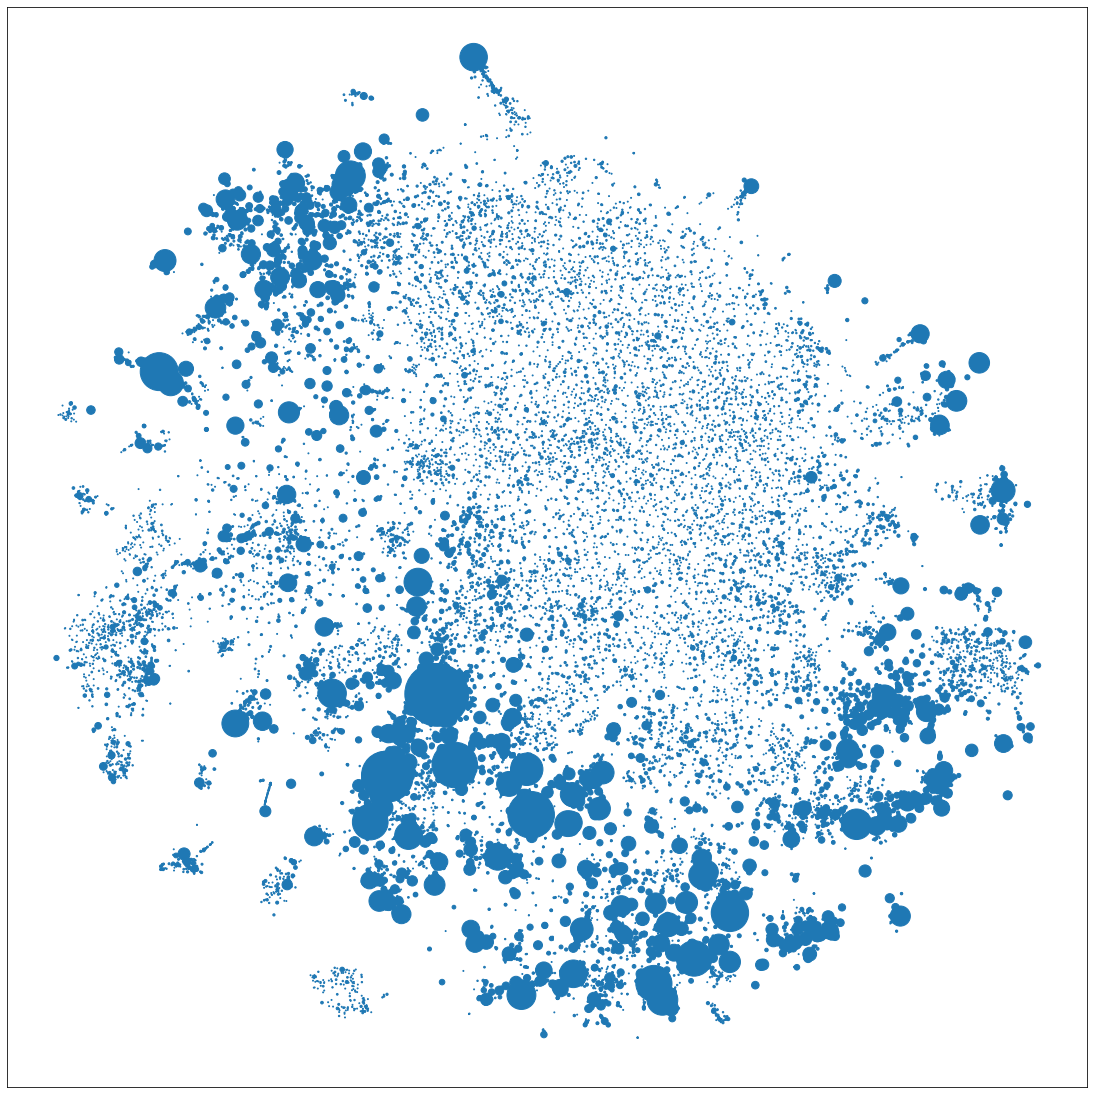

In [8]:
# --- Visualization -----

# Size of nodes = amount of interactions of nodes: indegree+outdegree
interactions = [deg[1] for deg in G.in_degree]

# Entire network, just nodes
fig = plt.figure(figsize = (15,15))
ax = fig.add_axes([0,0,1,1])
nx.draw_networkx_nodes(G, pos, node_size = interactions)
plt.savefig('Output/Reddit_Hyperlink_network.png', dpi=300, bbox_inches = 'tight')

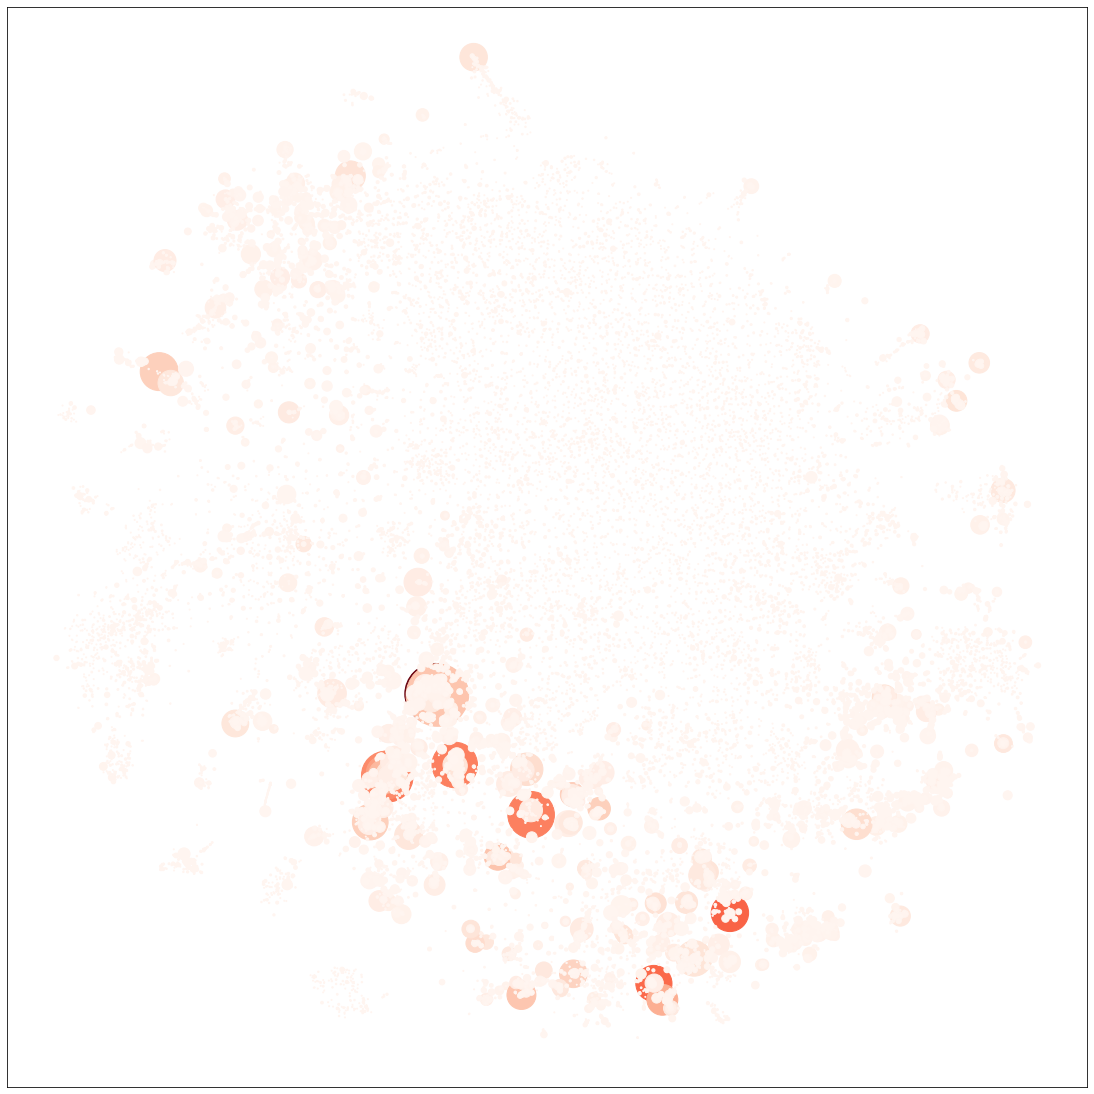

In [9]:
# Color intensity of nodes = amount of incoming negative edges 
inn = in_neg.to_dict()
colors = [inn[node] for node in G.nodes()]


# Entire network, just nodes weighted by incoming negative edges
fig = plt.figure(figsize = (15,15))
ax = fig.add_axes([0,0,1,1])
nx.draw_networkx_nodes(G, pos, node_size = interactions,
                       node_color = colors,
                       cmap = plt.cm.get_cmap('Reds'))
plt.savefig('Output/Reddit_Hyperlink_network_incoming_negative_edges.png', dpi=300, bbox_inches = 'tight')

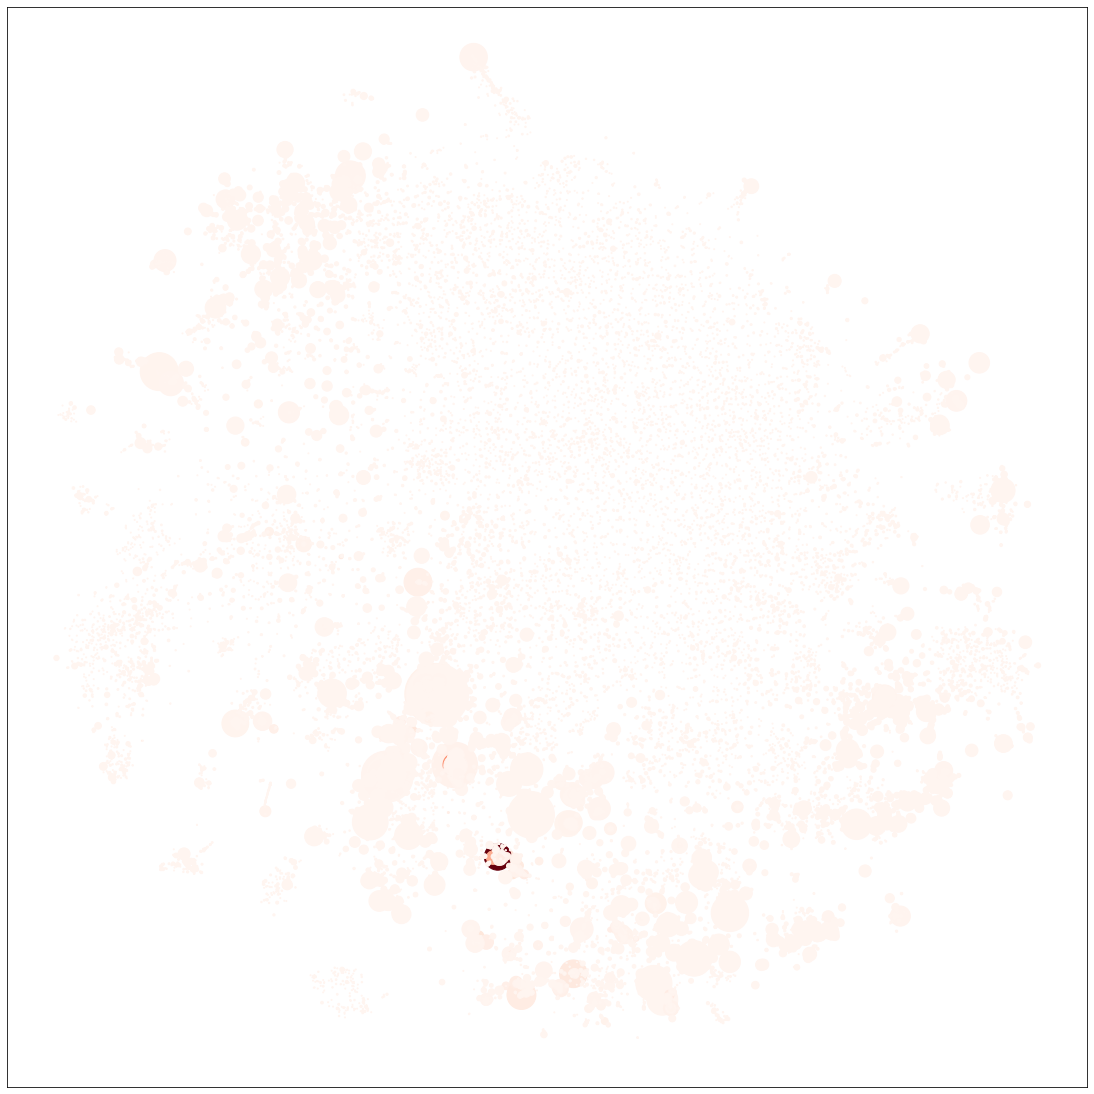

In [10]:
# Color intensity of nodes = amount of outgoing negative edges 
onn = out_neg.to_dict()
colors = [onn[node] for node in G.nodes()]


# Entire network, just nodes weighted by outgoing negative edges
fig = plt.figure(figsize = (15,15))
ax = fig.add_axes([0,0,1,1])
nx.draw_networkx_nodes(G, pos, node_size = interactions,
                       node_color = colors,
                       cmap = plt.cm.get_cmap('Reds'))
plt.savefig('Output/Reddit_Hyperlink_network_outgoing_negative_edges.png', dpi=300, bbox_inches = 'tight')

In [ ]:
negative_edges = HL[HL.LINK_SENTIMENT <0][['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']].to_numpy()
negative_edges = [tuple(e) for e in negative_edges]
negative_weights = [w for w in HL[HL.LINK_SENTIMENT <0].WEIGHT]

positive_edges = HL[HL.LINK_SENTIMENT >=0][['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']].to_numpy()
positive_edges = [tuple(e) for e in positive_edges]
positive_weights = [w for w in HL[HL.LINK_SENTIMENT >=0].WEIGHT]

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_axes([0,0,1,1])
nx.draw_networkx_nodes(G, pos, node_size = degrees, node_color = colors,
                       #v_min = 0, v_max = in_neg_max,
                       cmap = plt.cm.get_cmap('Reds'), )
#nx.draw_networkx_edges(HLG, pos, edgelist = negative_edges, edge_color='red',
#                       width = negative_weights, alpha = 1 )
#nx.draw_networkx_edges(HLG, pos, edgelist = positive_edges, edge_color='black',
#                       width = positive_weights, alpha = 0.4)


plt.savefig('Weighted_Graph_PCA.png', dpi=200, bbox_inches = 'tight')